# Inputs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Preproccess

## read data

In [2]:
from utils.class_patient import Patients


patients = Patients.loadPatients()
len(patients)

1213

## remove missing

In [3]:
# fill measures whose null represent false value

from constants import NULLABLE_MEASURES


nullableMeasures = NULLABLE_MEASURES

for measureName in nullableMeasures:
    patients.fillMissingMeasureValue(measureName, 0)

In [4]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


In [5]:
# remove patients with less than 80% of data

patients.removePatientByMissingFeatures()
len(patients)

1206

In [6]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [7]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


## split patients

In [8]:
splitedPatients = patients.split(splitPartCount, splitSeed)

len(splitedPatients[0])

225

In [9]:
splitedPatients = patients.split(splitPartCount, splitSeed)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

In [10]:
for trainPatients, testPatients in trainTest():
    print(len(trainPatients.patientList), len(testPatients.patientList))

899 225
899 225
899 225
899 225
900 224


# LSTM

### Seperate static and dynamic

In [11]:
from keras.models import Sequential, Model
from keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Input,
    Concatenate,
    Masking,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf


def createModel2(timeSteps, timeFeatures):
    # time series layers
    timeInputLayer = Input(shape=(timeSteps, timeFeatures))
    # maskingLayer = Masking(mask_value=0.0)(timeInputLayer)
    # cnnLayer = Conv1D(64, 3, activation="relu", kernel_regularizer=l2(0.01))(maskingLayer)
    # batNormCnn = BatchNormalization()(cnnLayer)
    # poolingLayer = MaxPooling1D(2)(batNormCnn)
    seriesLayer = LSTM(64, return_sequences=True)(timeInputLayer)
    dropout1 = Dropout(0.2)(seriesLayer)
    seriesLayer2 = tf.keras.layers.GlobalAveragePooling1D()(dropout1)
    dense2 = Dense(1, activation="sigmoid")(seriesLayer2)

    model = Model(inputs=timeInputLayer, outputs=dense2)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["AUC", "accuracy", "precision", "recall"],
    )

    return model

2024-08-22 14:41:03.218755: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 14:41:03.225033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 14:41:03.232457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 14:41:03.235619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 14:41:03.242508: I tensorflow/core/platform/cpu_feature_guar

In [16]:
from utils.prepare_data import normalizeData, patientsToNumpy
from constants import CATEGORICAL_MEASURES
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


if __name__ == "__main__":

    loses = []
    aucs = []
    accuracies = []
    precisions = []
    recals = []

    train_loss_list = []
    val_loss_list = []
    models = []

    for i, (trainPatients, valPatients, testPatients) in enumerate(trainValTest()):
        npTrainX, dataNormalizer = patientsToNumpy(
            trainPatients, 
            hoursPerWindow,
            timeSeriesOnly=True,
            fromHour=0,
            toHour=12,
        )

        npTestX, *_ = patientsToNumpy(
            testPatients,
            hoursPerWindow,
            timeSeriesOnly=True,
            fromHour=0,
            toHour=12,
            dataNormalizer=dataNormalizer,
            isTrainPatients=False,
        )

        npValX, *_ = patientsToNumpy(
            valPatients,
            hoursPerWindow,
            timeSeriesOnly=True,
            fromHour=0,
            toHour=12,
            dataNormalizer=dataNormalizer,
            isTrainPatients=False,
        )

        npTrainX = np.nan_to_num(npTrainX, nan=0)
        npTestX = np.nan_to_num(npTestX, nan=0)
        npValX = np.nan_to_num(npValX, nan=0)

        ################### Static ###################
        staticTrainX = trainPatients.getMeasuresBetween(measureTypes="static")
        staticTestX = testPatients.getMeasuresBetween(measureTypes="static")
        staticValX = valPatients.getMeasuresBetween(measureTypes="static")

        staticTrainX = staticTrainX.drop(
            columns=["subject_id", "hadm_id", "stay_id", "akd"]
        )
        staticTestX = staticTestX.drop(
            columns=["subject_id", "hadm_id", "stay_id", "akd"]
        )
        staticValX = staticValX.drop(
            columns=["subject_id", "hadm_id", "stay_id", "akd"]
        )

        staticTrainX, staticTestX, staticValX = normalizeData(
            staticTrainX, staticTestX, staticValX
        )

        staticLen = len(staticTrainX.columns)

        staticTrainX = staticTrainX.to_numpy().astype(np.float32)
        staticTestX = staticTestX.to_numpy().astype(np.float32)
        staticValX = staticValX.to_numpy().astype(np.float32)  # type: ignore

        staticTrainX = np.nan_to_num(staticTrainX, nan=0)
        staticTestX = np.nan_to_num(staticTestX, nan=0)
        staticValX = np.nan_to_num(staticValX, nan=0)

        ################### labels ###################
        trainY = [p.akdPositive for p in trainPatients]
        testY = [p.akdPositive for p in testPatients]
        valY = [p.akdPositive for p in valPatients]

        # model = createModel2(npTrainX.shape[1], npTrainX.shape[2], staticLen)

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        # expand static data to be time steps as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)

        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=50, restore_best_weights=True
        )

        model = createModel2(npTrainX.shape[1], npTrainX.shape[2])
        history = model.fit(
            npTrainX,
            np.array(trainY),
            epochs=1000,
            batch_size=32,
            validation_data=(npValX, np.array(valY)),
            class_weight=weight,
            callbacks=[early_stopping],
        )

        loss, auc, accuracy, precison, recal = model.evaluate(npTestX, np.array(testY))

        # model.save(f"result/lstm_only_{i}.h5")

        models.append(model)
        loses.append(loss)
        aucs.append(auc)
        accuracies.append(accuracy)
        precisions.append(precison)
        recals.append(recal)

        train_loss_list.append(history.history["loss"])
        val_loss_list.append(history.history["val_loss"])

        pass

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.5317 - accuracy: 0.5570 - loss: 0.6823 - precision: 0.3522 - recall: 0.4818 - val_AUC: 0.5784 - val_accuracy: 0.5754 - val_loss: 0.6794 - val_precision: 0.4000 - val_recall: 0.4516
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.6381 - accuracy: 0.6154 - loss: 0.6540 - precision: 0.4278 - recall: 0.5365 - val_AUC: 0.6761 - val_accuracy: 0.6704 - val_loss: 0.6548 - val_precision: 0.5205 - val_recall: 0.6129
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7299 - accuracy: 0.6646 - loss: 0.6352 - precision: 0.5223 - recall: 0.6524 - val_AUC: 0.7254 - val_accuracy: 0.6983 - val_loss: 0.6339 - val_precision: 0.5541 - val_recall: 0.6613
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7398 - accuracy: 0.6847 - loss: 0.6164 - precision: 0.5276 - recall: 0.6818 - val_AUC: 0.7482 - val_accuracy: 0.7039 - val_loss: 0.6172 - val_precision: 0.5600 - val_recall: 0.6774
Epoch 5/1000
23/23 ━━━━━━━━━━━━

In [15]:
print("Loses:", loses, np.mean(loses), np.std(loses))
print("AUCs:", aucs, np.mean(aucs), np.std(aucs))
print("Accuracies:", accuracies, np.mean(accuracies), np.std(accuracies))
print("Precisions:", precisions, np.mean(precisions), np.std(precisions))
print("Recals:", recals, np.mean(recals), np.std(recals))

Loses: [0.5193874835968018, 0.5523114204406738, 0.53188157081604, 0.4991479516029358, 0.5386692881584167] 0.5282795429229736 0.018034250081017784
AUCs: [0.8236525058746338, 0.8143206238746643, 0.8107768297195435, 0.8202704787254333, 0.7992624044418335] 0.8136565685272217 0.00848042919179673
Accuracies: [0.7555555701255798, 0.7555555701255798, 0.7066666483879089, 0.7511110901832581, 0.75] 0.7437777757644654 0.018693112260865192
Precisions: [0.6455696225166321, 0.6185566782951355, 0.5643564462661743, 0.649350643157959, 0.6122449040412903] 0.6180156588554382 0.030509039852281726
Recals: [0.6538461446762085, 0.7692307829856873, 0.7215189933776855, 0.6329113841056824, 0.7692307829856873] 0.7093476176261901 0.05699656247362463


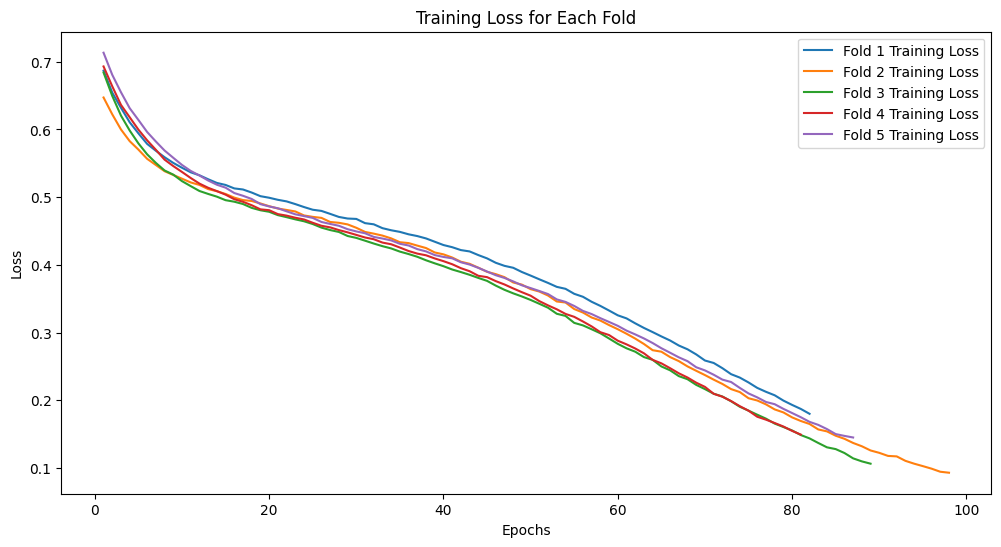

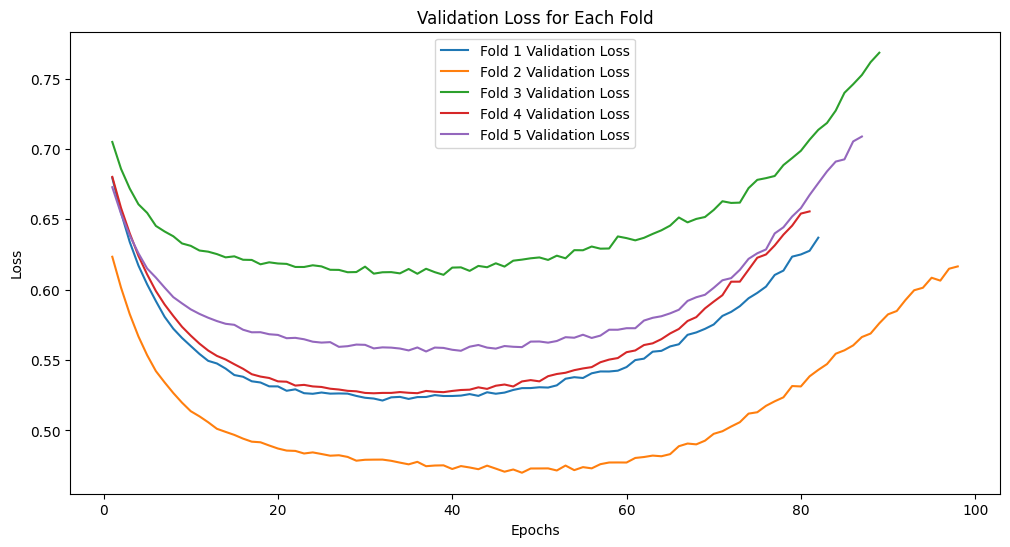

In [17]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1), train_loss, label=f"Fold {i+1} Training Loss"
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(range(1, len(val_loss) + 1), val_loss, label=f"Fold {i+1} Validation Loss")
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()